In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from numpy.fft import fft2,ifft2
import cv2

# Question 1

<p>Degradation function: </p>
$$ H(u, v) = \frac{T}{\pi (ua + vb)} \sin[ \pi (ua + vb) ]e^{-j \pi (ua + vb)} $$

In [2]:
img = rgb2gray(np.array(cv2.imread("DIP.png")))

In [3]:
F = np.fft.fftshift(np.fft.fft2(img)) #shift zero-frequency component to the mean 

In [4]:
a, b, T = 0.05, 0.02, 1

In [5]:
def gauss_noise(data, v, u=0):
    """Adds in Gaussian noise to an image (data) based on value of mu and sigma"""
    x = np.abs(data)*255/np.abs(data).max()
    noisy_data = x + np.random.normal(u, v**0.5, data.shape)
    return noisy_data

In [6]:
def degradation(a=a, b=b, T=1, img=img):
    """
    Returns the output of a sample degradation function of motion blur in the frequency domain
    @Param:
    1. a - linear motion rate in the horizontal direction (spatial domain)
    2. b - linear motion rate in the vertical direction   (spatial domain)
    3. u - mean
    4. T - Motion blur parameter (time/spatial integration)
    5. img - Image to degrade (spatial domain)
    """
    M, N = img.shape
    
    for i in range(M):
        for j in range(N):
            img[i,j]= img[i,j]*(-1)**(i+j)
            
    F = fft2(img) #compute Fourier of image
    H = np.zeros(shape=(M, N)) #create the degredation filter 
    for u in range(M):
        for v in range(N):
            temp = np.pi*((u - M/2)*a + (v - N/2)*b)
            H[u,v] = T if (temp == 0) else T * np.sin(temp) * np.exp(-1j*temp) / temp
    
    output_fft = H * F
    g_freq = ifft2(output_fft).real
    G = np.zeros(shape=(M,N))
    
    for i in range(M):
        for j in range(N):
            G[i,j]= g_freq[i,j]*(-1)**(i+j)
        
    return G, H

In [7]:
G, H = degradation()

/Users/qasimwani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


In [8]:
noisy_1 = gauss_noise(np.abs(G), v=0.0065) #noise level set to 'lightly corrupted'
noisy_2 = gauss_noise(np.abs(G), v=65) #noise level set to 'midly corrupted'
noisy_3 = gauss_noise(np.abs(G), v=650) #noise level set to 'heavily corrupted'

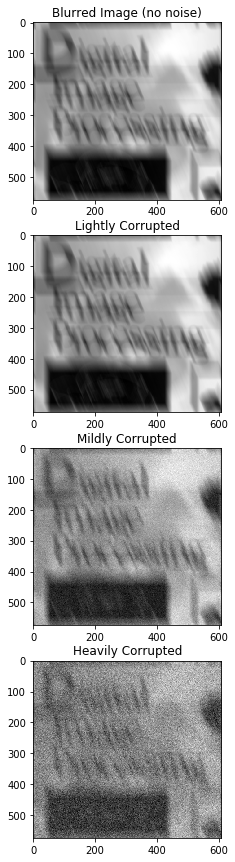

In [9]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(15,15))
ax0.imshow(np.abs(G), "gray"), ax0.set_title("Blurred Image (no noise)")
ax1.imshow(np.abs(noisy_1), "gray"), ax1.set_title("Lightly Corrupted")
ax2.imshow(np.abs(noisy_2), "gray"), ax2.set_title("Mildly Corrupted")
ax3.imshow(np.abs(noisy_3), "gray"), ax3.set_title("Heavily Corrupted")
plt.show()

# Question 2

<h4>Pseudo-Inverse Filter:</h4>
$$ \hat{F}(u,v) = G(u,v) H_{inv}(u,v)$$ 
$$\begin{equation*}
H_{inv}(u,v) = \left\{
\begin{array}{ll}
\frac{1}{H(u,v)} \qquad |H(u,v)| > \delta\\
\quad 0 \qquad \hspace{0.7em} |H(u,v)| \leq \delta
\end{array}
\right.
\end{equation*} $$

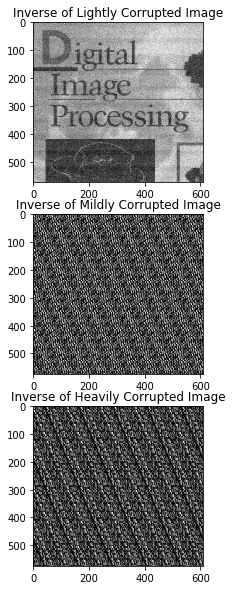

In [10]:
def pseudo_inverse_filter(degraded, delta=1e-3, H=H):
    """
    Computes the inverse and outputs the image in the spatial domain based on a degredation function.
    @Param:
    1. degraded - Degraded image (spatial domain)
    2. H - degredation function
    @Return:
    f_inverse - output of inverse filtering in the spatial domain
    """
    G = np.fft.fftshift(np.fft.fft2(degraded))
    H_inv = np.where(np.abs(H) > delta, 1/H, 0)
    F_inverse = G * H_inv
    f_inverse = np.fft.ifft2(np.fft.ifftshift(F_inverse))
    return np.abs(f_inverse)

#---------------------------------------------------------------------------------------------#

inverse_noisy_1 = pseudo_inverse_filter(noisy_1) #compute inverse of 'lightly corrupted' image
inverse_noisy_2 = pseudo_inverse_filter(noisy_2, 1e-15) #compute inverse of midly corrupted' image
inverse_noisy_3 = pseudo_inverse_filter(noisy_3, 1e-15) #compute inverse of 'heavily corrupted' image

#---------------------------------------------------------------------------------------------#

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,10))
ax1.imshow(inverse_noisy_1, "gray"), ax1.set_title("Inverse of Lightly Corrupted Image")
ax2.imshow(inverse_noisy_2, "gray"), ax2.set_title("Inverse of Mildly Corrupted Image")
ax3.imshow(inverse_noisy_3, "gray"), ax3.set_title("Inverse of Heavily Corrupted Image")
plt.show()

<h4>Weiner Filter:</h4>
$$ \hat{F}(u, v) = 
\frac{ \lvert H(u, v) \rvert^2 G(u, v) }
    { H(u, v) (\lvert H(u, v) \rvert^2 + 
                            \frac{S_\eta(u, v)}{S_f(u, v)} ) }
$$
<br>
where
$ S_\eta(u, v) = \lvert N(u, v) \rvert^2 $, autocorrelation of noise
<br>
and $ S_f(u, v) = \lvert F(u, v) \rvert^2 $, undegraded image power spectrum
<br>
<br>
<h4>Alternatively, this can be represented as: </h4>
$$ \hat{F}(u, v) = 
\frac{ \lvert H(u, v) \rvert^2 G(u, v) }
    { H(u, v) ( \lvert H(u, v) \rvert^2 + K)}
$$
<br>
where $K$ is an unspecified constant that is added to all terms of $\lvert H(u, v) \rvert^2$

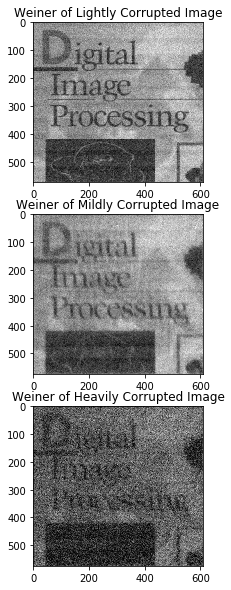

In [11]:
def weiner(g, H=H,K=1e-2):
    """
    Restore an image using Weiner filter and output the image in the spatial domain.
    @Param:
    1. g - output from a degredation function (spatial domain)
    2. H - degradation function
    3. K - constant added to |H(u, v)|^2
    @Return:
    f_restored - output of applying weiner filter to restore degraded image, g.
    """
    G = np.fft.fftshift(np.fft.fft2(g)) #zero-center and calculate the fourier of degraded image, g.
    H_norm = np.abs(H)**2 #dot product of H_conj and H; alternatively, H.T @ H
    num = H_norm * G
    den = H * (H_norm + K)
    F_inverse = num/den
    f_restored = np.fft.ifft2(np.fft.ifftshift(F_inverse))
    return np.abs(f_restored)

#---------------------------------------------------------------------------------------------#

weiner_noisy_1 = weiner(noisy_1, K=1e-12) #'lightly corrupted' image restoration via Weiner filter
weiner_noisy_2 = weiner(noisy_2) #'midly corrupted' image restoration via Weiner filter
weiner_noisy_3 = weiner(noisy_3) #'heavily corrupted' image restoration via Weiner filter

#---------------------------------------------------------------------------------------------#

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,10))
ax1.imshow(weiner_noisy_1, "gray"), ax1.set_title("Weiner of Lightly Corrupted Image")
ax2.imshow(weiner_noisy_2, "gray"), ax2.set_title("Weiner of Mildly Corrupted Image")
ax3.imshow(weiner_noisy_3, "gray"), ax3.set_title("Weiner of Heavily Corrupted Image")
plt.show()